# Spin Chain Replication

## 1. Problem specification

The sample is a one-dimensional spin chain with dimensions: 
- length $l_{x} = 60\text{nm}$,
- width $l_{y} = 4\text{nm}$, and
- depth $l_{z} = 4\text{nm}$.

The material parameters are YIG-like:
- exchange energy constant, A = $1.6\times10^{-11}\text{J/m}$,
- saturation magnetisation, $M_{s} = 800\text{kA/m}$,
- Dzyaloshinskii-Moriya interaction constant, $D = 1.5\text{mJ/m}^{2}$,
- Gilbert damping, $\alpha = 1\times10^{-4}$, and
- gyromagnetic ratio, $\gamma = 29.2 \text{GHz/rad T}$.

The magnetisation dynamics are governed by the Landau-Lifshitz-Gilbert equation:
\begin{equation}
\frac{d\mathbf{m}}{dt} = -\gamma_{0} (\mathbf{m} \times \mathbf{H}_{\text{eff}}) + \alpha (\mathbf{m} \times \frac{d\mathbf{m}}{dt}),
\end{equation}
where $\gamma_{0} = \gamma \mu_{0}$, $\mu_{0}$ is the magnetic constant, and $\mathbf{H}_{\text{eff}}$ is the effective field.

The effective field is given by:
\begin{equation}
\mathbf{H}_{\text{eff}} = -\frac{1}{\mu_{0} M_{s}} \frac{\delta W}{\delta \mathbf{m}},
\end{equation}
where $W$ is the total energy of the system.

In this problem, the system is set at a known magnetisation state which is assumed to be an equilibrium state. The system is then perturbed by a time-dependent Zeeman magnetic field $h_{x,t}$ in the $\hat{x}$ direction. The boundaries of the problem are handled by fixing the magnetisation of the first and last spins in the chain.


## 2. Python setup

### 2.1. General Tools

Once a cell has been run any defined variables are stored in memory and can be accessed by any other cell. This is useful for defining constants, functions, and other objects that are used throughout the notebook. However, it may be desirable to clear all variables from memory and start from scratch. This can be done by running the following cell:

In [409]:
%reset -f  # magic command
# %reset?  # magic command help

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  magic, please run `%reset?` for details
Don't know how to reset  command, please run `%reset?` for details


### 2.2. Python setup

#### 2.2.1. Common Python modules

Place common Python modules here.

In [410]:
import matplotlib.pyplot as plt
import numpy as np

#### 2.2.2. Ubermag modules

Place Ubermag modules here.

In [411]:
import discretisedfield as df
import micromagneticmodel as mm

#### 2.2.3. Ubermag calculators

Place Ubermag calculators here.

In [412]:
import oommfc as oc

In [413]:
# OOMMF test: Check if the runner is active
# oc.runner.runner.status  

## (Aside) Simulation parameters

Normally there would be a section here, of code, that would allow the user to input parameters for the simulation. However, for the purposes of this notebook, we will hard-code the parameters into the notebook as the are required.

## 3. Define our system (spin chain)

Each micromagnetic simulation is construed as a model which a micromagnetic calculator is then able to interpret and simulate. In Übermag each model is uniquely represented as a container called `mm.System`. In order to populate the container we need to provide:

1. The energy equation,
2. The magnetisation field,
3. The dynamics equations,
4. The temperature of the system, and
5. The name of the system.

In this section we will work through each `mm.System` parameter in turn.

Note: The name of the system, and all other `name` `**kwargs` for that matter, must not container underscores `_` as this leads to errors within the Übermag framework.

### 3.1. System name

In [414]:
system_spinchain = mm.System(name='PrimarySpinchain')

### 3.2. Energy equation

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Energy.html#micromagneticmodel.Energy)

The *energy terms* can be stored either a container class `mm.Energy(terms=None)`, or directly in a system `mm.System.energy(terms=myEnergyTerms)`. Both container options are fundamentally composed of children and siblings that inherit their properties from the `mm.EnergyTerm(**kwargs)` [parent class](https://ubermag.github.io/api/_autosummary/micromagneticmodel.EnergyTerm.html#micromagneticmodel.EnergyTerm).

To build our energy equation we can:
1. define an empty list and append each term to the list through the `append` method.
2. define each `EnergyTerm` object and then combine them into a list: 
- `energy_terms = [term1, term2, term3]`.
- `energy_terms = term1 + term2 + term3`.

It's then a simple matter to do `system.energy = mm.Energy(terms=energy_terms)`.

Note: It is possible to initialise an empty variable with `energy_terms = None` and append to it through `+=`. However, the first term must be assigned to the variable, not appended. So this is method normally just adds boilerplate code.

In [415]:
#spinchain_energy_terms = None

#### 3.2.1. Static zeeman energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Zeeman.html#micromagneticmodel.Zeeman). 

It's important to note that:
- This term covers both static, *i.e.* $\mathbf{H}_{0}$, and dynamic, *i.e.* $\mathbf{h}_{(x,t)}$, magnetic fields.
- If one wants to include more than one `mm.Zeeman()` in the same region then these Zeeman energies **must** be given different names.

In [416]:
# Align along the z-direction
spinchain_H0 = (0, 0, 0.1)  # (T) 

If our initial pumping field strength was given in $T$ then we need to convert to a tuple in the required units $A/m$.

In [417]:
spinchain_H0 = tuple([x/mm.consts.mu0 for x in spinchain_H0])  # (A/m)

We can now create the static Zeeman energy term, give it an appropriate name to uniquely identify it, and append to the region's `EnergyTerm` container. If we don't want to reuse `spinchain_Hext_static`, such as to print it or add it to another system, then we can simply append it to `system_spinchain.energy`.

Remember that the first term must be assigned, not appended.

In [418]:
spinchain_zeeman_static = mm.Zeeman(H=spinchain_H0, 
                                    name='SpinchainZeemanStatic')

In [419]:
system_spinchain.energy = spinchain_zeeman_static 

To avoid an odd behaviours, particularly with graphical outputs or text involving the Math environment, it is best to handle output in a separate cell to an assingment. This is because the output of the assignment is the object itself, and not the output of the object's `__repr__` method.

In [420]:
# Print equation of Zeeman energy
# spinchain_zeeman_static

#### 3.2.2. Dynamic zeeman energy

See comments for Section 3.2.1.

In [421]:
# Pumping field strength
spinchain_h0 = (3e-3, 0, 0)  # (T)

# Driving (cut-off) frequency
spinchain_freq = 15e9  # (Hz)

# Time to adjust the phase (time shift) of a wave [t - t0]
spinchain_timeshift = 0  # (s)

# Time steps to evaluate at
stepsize = 1e-15  # (s)

In [422]:
spinchain_h0 = tuple([x/mm.consts.mu0 for x in spinchain_h0])  # (A/m)

Now we can create the dynamic Zeeman energy term, give it an appropriate name to uniquely identify it, and append to the region's `EnergyTerm` container. 

If the `name` `**kwargs` is not provided then an `EnergyTerm` is provided the `name` `**kwarg` then the default value is used. When a single `mm.System` has two or more `mm.EnergyTerm` with the same name value, including the default, then an error is thrown.

Notice that if we didn't use a `func` to define any oscillatory behaviour then we would return the *ZeemanStatic* case.

In [423]:
spinchain_zeeman_dynamic = mm.Zeeman(H=spinchain_h0, 
                                    name='SpinchainZeemanDynamic',
                                    func='sin',
                                    f=spinchain_freq,
                                    t0=spinchain_timeshift,
                                    dt=stepsize)

In [424]:
# Not the first term so we now append
# system_spinchain.energy += spinchain_zeeman_dynamic

In [425]:
# Print equation of Zeeman energy
# spinchain_zeeman_dynamic

#### 3.2.3. (Heisenberg) Exchange energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Exchange.html#micromagneticmodel.Exchange).

Be cautious! Übermag requires that we provide an exchange interaction energy in $J/m$ and not in $T$ like we normally use!

In [426]:
# Exchange interaction energy, A
spinchain_exch_energy_const = 1.6e-11  # (J/m)

# Alternative way to define A
# spinchain_exch_energy_const = 0.5 * mm.consts.mu0 * Ms**2 * lex**2

Similar to §3.2.2, we can create the exchange energy term, give it an appropriate name to uniquely identify it, and append to the region's `EnergyTerm` container.

In [427]:
spinchain_exchange_energy = mm.Exchange(A=spinchain_exch_energy_const,
                                        name='SpinchainExchange')

In [428]:
system_spinchain.energy += spinchain_exchange_energy

In [429]:
# Print equation of Heisenberg exchange energy
# spinchain_exchange_energy

#### 3.2.4. Dzyaloshinskii-Moriya interaction energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.DMI.html#micromagneticmodel.DMI).

Ubermag added additional extensions to OOMMF enabling the use of the DM interaction in more generalised cases for both interfacial and bulk. Therefore, one must pass both a $D_{i,j}$ constant and a crystalographic classification (`crystalclass`) to `mm.DMI()`. The possible values for `crystalclass` are:
- `T` (transverse),
- `O` (longitudinal),
- `Cnv` (cyclical), and
- `D2d` (dihedral).

Both cyclical and dihedral also require the provision of the norm's direction through appending an underscore `_` and the cardinal direction, *e.g.* `Cnv_x`.

In [430]:
# Crystalographic classification
spinchain_dmi_crystalclass = 'T'

# Microscopic DM interaction constant
spinchain_dmi_D = 1.5e-3  # (J/m^2)

In [431]:
spinchain_dmi_energy = mm.DMI(D=spinchain_dmi_D, 
                              crystalclass=spinchain_dmi_crystalclass,
                              name='SpinchainDMI')

In [432]:
# Append to EnergyTerm
system_spinchain.energy += spinchain_dmi_energy

In [433]:
# Print equation of DM interaction energy term
# spinchain_dmi_energy

#### 3.2.5. Demagnetisation energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Demag.html#micromagneticmodel.Demag).

Unless there is an *asymptotic radius* to consider then this simply involves a method call. 

Note: Adding $\mathbf{H}_{demag}$ to a simulation greatly increases the computational cost per iteration of the numerical model, and consequentually the total (real-world) runtime!

In [434]:
spinchain_demag_energy = mm.Demag(name='SpinchainDemag')

In [435]:
# Append to EnergyTerm
system_spinchain.energy += spinchain_demag_energy

In [436]:
# Print equation of DM interaction energy term
# spinchain_demag_energy

#### 3.2.6. Hamiltonian

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Energy.html#micromagneticmodel.Energy).

If we collected the various energy terms in a separate container then we now need to assign this to the system's energy. If we used `system.energy += term` then we can skip this step.

In [437]:
# Uncomment if needed
# system_spinchain.energy =  mm.Energy(terms=spinchain_energy_terms)

At this stage, we've defined our Hamiltonian! By invoking `system.energy` like a function we are able to utilise the `__repr__` method (provided by Übermag) to print out the Hamiltonian in a human-readable format.

In [438]:
print(f'This energy equation has {len(system_spinchain.energy)} terms, and is given by the following equation')

# Print equation of system's energy terms
system_spinchain.energy

This energy equation has 4 terms, and is given by the following equation


Zeeman(H=(0.0, 0.0, 79577.47154594767)) + Exchange(A=1.6e-11) + DMI(D=0.0015, crystalclass='T') + Demag()

### 3.3. Dynamics equation

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Dynamics.html#micromagneticmodel.Dynamics).

The *dynamics terms* are defined in an identical way to the *energy terms*. They can also be stored in either a container class `mm.Dynamics(terms=None)`, or directly in a system `mm.System.dynamics(terms=myDynamicsTerms)`. Both container options are fundamentally composed of children and siblings that inherit their properties from the `mm.DynamicsTerm(**kwargs)` [parent class](https://ubermag.github.io/api/_autosummary/micromagneticmodel.DynamicsTerm.html#micromagneticmodel.DynamicsTerm).

In [439]:
#spinchain_dynamics_terms = None

#### 3.3.1. Precession term

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Precession.html#micromagneticmodel.Precession).

In [440]:
# Gyrotropic ratio (A*s/kg) i.e. (C/kg)
spinchain_gamma = 2 * np.pi * 29.2e9  # (Hz/rad*T)

# Gyromagnetic ratio
spinchain_gamma0 = spinchain_gamma * mm.consts.mu0  # (m/A*s)

In [441]:
spinchain_dynamics_precession = mm.Precession(gamma0=spinchain_gamma0,
                                     name='SpinchainPrecession')

In [442]:
# First DynamicsTerm so we assign instead of append
system_spinchain.dynamics = spinchain_dynamics_precession

In [443]:
# Print equation of the precession dynamics term
# spinchain_dynamics_precession

#### 3.3.2. Damping term

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Damping.html#micromagneticmodel.Damping).

In [444]:
spinchain_gilbert_factor = 1e-4

In [445]:
spinchain_dynamics_damping = mm.Damping(alpha=spinchain_gilbert_factor,
                                       name='SpinchainDamping')

In [446]:
system_spinchain.dynamics += spinchain_dynamics_damping

In [447]:
# Print equation of the damping dynamics term
# spinchain_dynamics_damping

#### 3.3.3. Dynamics equation

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Dynamics.html#micromagneticmodel.Dynamics).

The dynamics equation is now complete! By invoking `system.dynamics` like a function we are able to utilise the `__repr__` method (provided by Übermag) to print out the dynamics equation in a human-readable format.

If we collected the various dynamics terms in a separate container then we now need to pass this to the system's dynamics argument. If we used `system.dynamics += term` then we can skip this step.

In [448]:
# Uncomment if needed
# system_spinchain.dynamics = mm.Dynamics(terms=spinchain_dynamics_terms)

In [449]:
print(f'This dynamics equation has {len(system_spinchain.dynamics)} terms, and is given by the following equation')

# Print out equation of system's dynamics terms
system_spinchain.dynamics

This dynamics equation has 2 terms, and is given by the following equation


Precession(gamma0=230553.95880944742) + Damping(alpha=0.0001)

### 3.4. Magnetisation field

The magnetisation field is defined by the `df.Field` class with is then included in the system through `mm.System.m. There is a large amount of flexibility in how the field can be defined, so do read the documentation for each of the subsections but especially §3.4.3.

#### 3.4.1. Region

[Documentation page](https://ubermag.github.io/api/_autosummary/discretisedfield.Region.html#discretisedfield.Region).

Each mesh (seen in §3.4.2) requires is composed of at least one region; implicitly through default actions or explicitly as we shall do in §3.4.1. If a system only has a single region then it is common to define the region (and mesh) before handling the energy, dynamics, and magnetisation field components.

In [450]:
# Geometry
spinchain_lx = 60e-9  # (m)
spinchain_ly = 3e-9  # (m)
spinchain_lz = 3e-9  # (m)

In [451]:
# Starting point, p1
spinchain_region1_p1 = (0, 0, 0)

# End point, p2, which is diagonally opposite p1
spinchain_region1_p2 = (spinchain_lx, spinchain_ly, spinchain_lz)

Two optional parameters have been included in the `df.Region` class:
- `dims` which is a list of the region's dimensions that are used for labelling on plots, and
- `units` which is a list of the region's units.
- 
These default to `['x', 'y', 'z']` and `['m', 'm', 'm']` respectively for a 3D region. If a 2D region is used then the `dims` list should be `['x', 'y']` and the `units` list should be `['m', 'm']` *etc*.

In [452]:
spinchain_region1 = df.Region(p1=spinchain_region1_p1,
                             p2=spinchain_region1_p2,
                             dims=['x', 'y', 'z'],
                             units=['m', 'm', 'm'])

#### 3.4.2. Subregions

[Example page](https://ubermag.github.io/examples/notebooks/fixed-subregions.html).

A region can be split into unique subdivisions called `subregions`. This approach greatly simplifies generating multilayer structures as one doesn't need to treat each layer as an independent entity or system; reducing boilerplate code. To create our subregions we define a dictionary of `df.Region` objects. 

I find it easiest to define the cell size first (which is required by `df.Mesh`) because this lets us scale subregions in a more intuitive manner by generating the number of cells in each dimension.

Note: Ensure that the subregions remain within the bounds of the parent region. This can be checked through the `df.Region.__contains__()` method.

In [453]:
# Mesh discretisation cell size
spinchain_mesh_cell_size = (3e-9, 3e-9, 3e-9)  # (m, m, m)

# Number of discretised cells in each dimension
spinchain_mesh_num_cells = (spinchain_lx/spinchain_mesh_cell_size[0],
                            spinchain_ly/spinchain_mesh_cell_size[1],
                            spinchain_lz/spinchain_mesh_cell_size[2])

For a 1D spin chain where the fixed subregions are at both ends of the spin chain and are one cell size in length, we can define the subregions by:
- by providing the `p1` and `p2` coordinates for each subregion, or
- by providing the `p2` coordinate for each subregion knowing that the `p1` coordinate is the coordinate of the preceding subregion.

I've done the latter here while using `spinchain_mesh_num_cells[1], spinchain_mesh_num_cells[2]` to ensure that all subregions span the entire $\hat{y}$ and $\hat{z}$ dimensions.

In [454]:
spinchain_subregions_names = ['fixedLHS', 'driven', 'free', 'fixedRHS']

spinchain_subregions_p2 = {spinchain_subregions_names[0]: (1, 'all', 'all'),
                           spinchain_subregions_names[1]: (3, 'all', 'all'),
                           spinchain_subregions_names[2]: (59, 'all', 'all'),
                           spinchain_subregions_names[3]: (60, 'all', 'all')}

# Convert the subregion p2 coordinates
for key, value in spinchain_subregions_p2.items():
    value = list(value)
    # Replace 'all' with the number of cells in the corresponding dimension
    for i, val in enumerate(value):
        if val == 'all':
            value[i] = spinchain_mesh_num_cells[i]
    # Multiply by the mesh cell size to get the correct units
    spinchain_subregions_p2[key] = tuple([x*spinchain_mesh_cell_size[i] for i, x in enumerate(value)])

We can now define the subregions, ensuring that each subregion is within the bounds of the parent region and has a unique name.

In [455]:
spinchain_subregions = {spinchain_subregions_names[0]: df.Region(p1=spinchain_region1_p1,
                                              p2=spinchain_subregions_p2['fixedLHS']),
                        spinchain_subregions_names[1]: df.Region(p1=(spinchain_subregions_p2['fixedLHS'][0],0,0),
                                            p2=spinchain_subregions_p2['driven']),
                        spinchain_subregions_names[2]: df.Region(p1=(spinchain_subregions_p2['driven'][0],0,0),
                                          p2=spinchain_subregions_p2['free']),
                        spinchain_subregions_names[3]: df.Region(p1=(spinchain_subregions_p2['free'][0],0,0),
                                          p2=spinchain_region1_p2)}

#### 3.4.2. Mesh

[Documentation page](https://ubermag.github.io/api/_autosummary/discretisedfield.Mesh.html#discretisedfield.Mesh).

Now that we have bounded a region in space we can discretise it. This results in a mesh which is defined by the `df.Mesh` class which requires a region and a cell size. The region can be generated internally by `df.Mesh` through the provision of the same `p1` and `p2` arguments as `df.Region`. However, it is best practice to define the region explicitly, as we have done in §3.4.1., to improve code readability and maintainability.

There are two mutually-exclusive ways to discretise a region and create a mesh:
- pass `n` to `df.Mesh` which is a tuple of the number of discretisation cells in each dimension, and
- pass `cell` to `df.Mesh` which is a tuple of the length of each discretisation cell in each dimension.

In [456]:
spinchain_mesh = df.Mesh(region=spinchain_region1,
                         cell=spinchain_mesh_cell_size,
                         subregions=spinchain_subregions, )

ValueError: Subregion free is not in the mesh region.

We can print out the mesh to check how many total cells have been discretised as this will impact the computational cost of the simulation. It's also a good idea to plot the mesh to ensure that the discretisation has been done correctly - no subregions are overlapping and the full region is defined as intended.

In [457]:
print(f'Spinchain mesh (Num. discretised cells)\n'
      f'----------------\n'
      f' - X: {spinchain_mesh.n[0]}\n'
      f' - Y: {spinchain_mesh.n[1]}\n'
      f' - Z: {spinchain_mesh.n[2]}\n'
      f'----------------\n'
      f' - Total: {len(spinchain_mesh)}\n')

Spinchain mesh (Num. discretised cells)
----------------
 - X: 60
 - Y: 4
 - Z: 4
----------------
 - Total: 960



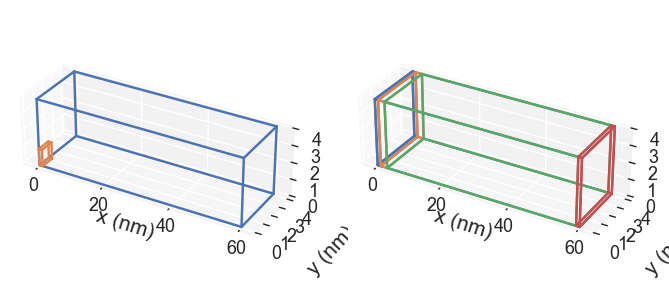

In [458]:
spinchain_mesh_fig = plt.figure(figsize=(8, 8))
spinchain_mesh_ax1 = spinchain_mesh_fig.add_subplot(121, projection='3d')
spinchain_mesh_ax2 = spinchain_mesh_fig.add_subplot(122, projection='3d')
# Print mesh (blue) with a single cell (orange) 
spinchain_mesh.mpl(ax=spinchain_mesh_ax1, box_aspect=(10, 3, 3), 
                   multiplier=1e-9)
# Print mesh (outlined) with: fixedLHS (ble), driven (orange), free (green), fixedRHS (red)
spinchain_mesh.mpl.subregions(ax=spinchain_mesh_ax2, box_aspect=(10, 3, 3),
                              multiplier=1e-9, show_region=True)

#### 3.4.3. Field

[Documentation page](https://ubermag.github.io/api/_autosummary/discretisedfield.Field.html#discretisedfield.Field).

We are now able to define the magnetisation field. The field is defined by the `df.Field` class which requires a mesh, the number of vector dimensions, the initial value of the field, and the norm of the field (the saturisation magnetisation $M_{\text{S}}$. The field can be defined in a number of ways:
- as a constant value,
- as a function of space,
- as a function of time,
- as a function of both space and time, or
- as a function of space and a scalar value.

In this case, we will define the initial magnetisation $\mathbf{\hat{m}}_{\text{0}}$ as a constant value. We carefully note that each subregion require their own definition.

Note: This approach we took to define the magnetisation can also be used to create customised fields such as an exchange field, $\mathbf{H}_{\text{exch}}$, or a demagnetisation field, $\mathbf{H}_{\text{demag}}$.

We first define the constants and then the initial magnetisation $\mathbf{\hat{m}}_{\text{0}}$. This enables us to defien the magnetisation field in a more readable manner.

In [459]:
# Saturisation magnetisation, Ms
spinchain_sat_mag  = 800e3  # (A/m)

# Number of vector dimensions
spinchain_num_dims = 3

In [460]:
# Initial magnetisation
spinchain_field_m0 = (1, 0, 0)

spinchain_field_subregions = {spinchain_subregions_names[0]: (0, 0, 1),
                                spinchain_subregions_names[1]: spinchain_field_m0,
                                spinchain_subregions_names[2]: spinchain_field_m0,
                                spinchain_subregions_names[3]: (0, 0, -1)}

We can now define the magnetisation field

In [461]:
system_spinchain.m = df.Field(mesh=spinchain_mesh, 
                                         nvdim=spinchain_num_dims, 
                                         value=spinchain_field_subregions, 
                                         norm=spinchain_sat_mag)

This is a good time to check the field to ensure that the initial magnetisation has been defined correctly.

/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


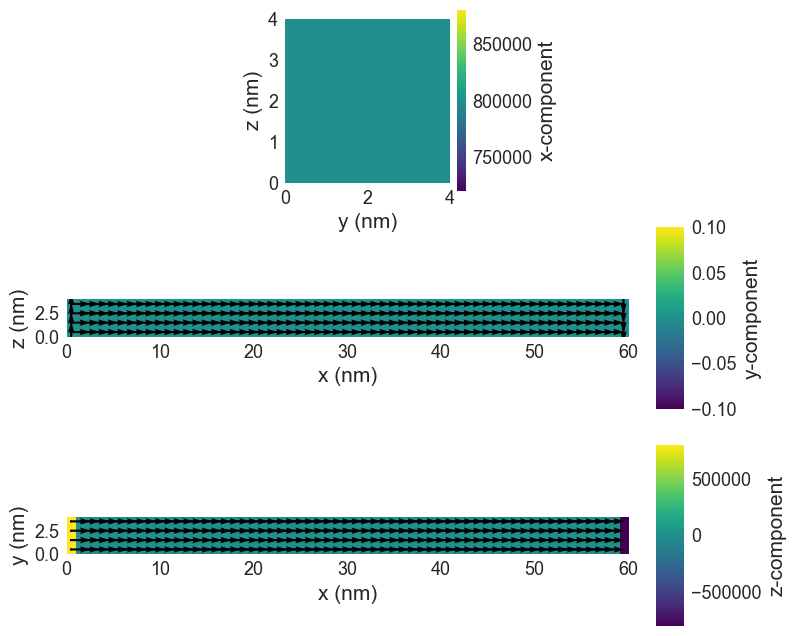

In [462]:
spinchain_field_fig = plt.figure(figsize=(8, 8))
spinchain_field_ax1 = spinchain_field_fig.add_subplot(311)
spinchain_field_ax2 = spinchain_field_fig.add_subplot(312)
spinchain_field_ax3 = spinchain_field_fig.add_subplot(313)

system_spinchain.m.sel('x').mpl(ax=spinchain_field_ax1)
system_spinchain.m.sel('y').mpl(ax=spinchain_field_ax2)
system_spinchain.m.sel('z').mpl(ax=spinchain_field_ax3)

## 4. Simulation

We'll now begin our simulation stages!

### 4.1. Step 1: minimise energy

The first step is to minimise the energy of the system and find an equilibrium state. Once this is achieved we can procede to our time-dependent drivers. If the system has been initialised in an equilibrium state then this step can be skipped.

#### 4.1.1. Create driver

[Übermag documentation: MinDriver()](https://ubermag.github.io/api/_autosummary/oommfc.MinDriver.html#oommfc.MinDriver)

This energy minimisation driver we will use, `MinDriver`, is an implementation of the OOMMF `Oxs_MinDriver` driver. It is used to minimise the energy of the system and find an equilibrium state. The driver is based on the conjugate gradient method. The allowed parameters come from the [OOMMF v2.0 Userguide 2020 (pp.89-90): Oxs_MinDriver](https://math.nist.gov/oommf/doc/userguide20b0/userguide.pdf). 


In [463]:
sim_stage1_mindriver = oc.MinDriver() 

#### 4.1.2. Run driver

Übermag has made several adaptations to try and simplify the process of passing parameters to drivers. These parameters will therefore not be found in the OOMMF documentation, but they can be found here in the [Übermag documentation of the parent class (oommfc.Driver()](https://ubermag.github.io/api/_autosummary/oommfc.Driver.html#oommfc.Driver). Some examples include:
- `n_threads` which is the number of threads to use for the calculation, and
- `fixed_subregions` which is a dictionary of the fixed subregions in the mesh.

After setting the driver's arguments we can now call the driver. This will begin the simulation as shown by the progressbar (activately via `verbose=2` below this notebook cell.
.
Note: It's important that we don't include any time-dependent contributions to `system.energy` while running an `oommfc.MinDriver()` as this will lead to an error.

In [464]:
sim_stage1_mindriver.drive(system_spinchain,
                           verbose=2,
                           fixed_subregions=[spinchain_subregions_names[0], spinchain_subregions_names[3]])

Running OOMMF (TclOOMMFRunner)[2024/05/18 21:48]... (1.1 s)


#### 4.1.3. Check output

##### 4.1.3.1 Vector plot with colour bar

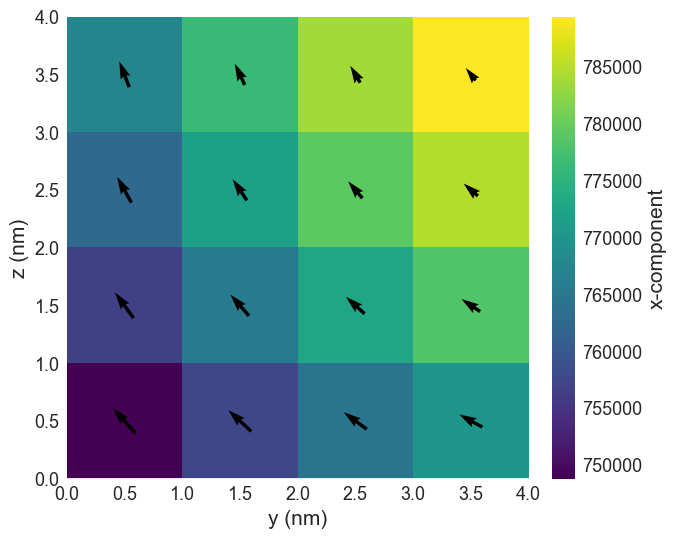

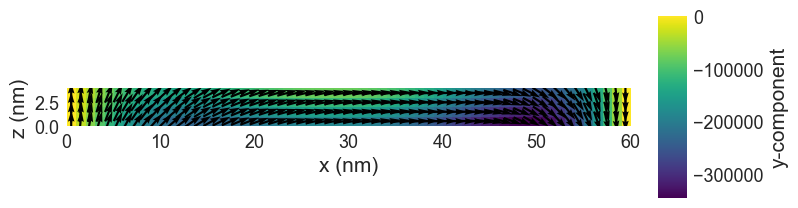

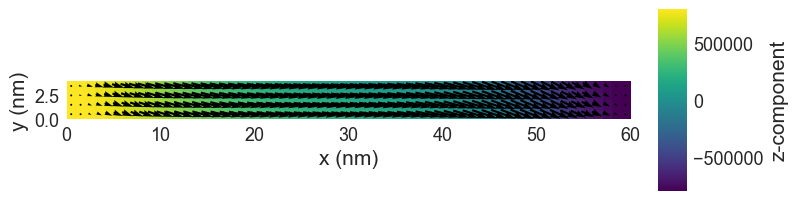

In [465]:
system_spinchain.m.sel('x').mpl()
system_spinchain.m.sel('y').mpl()
system_spinchain.m.sel('z').mpl()

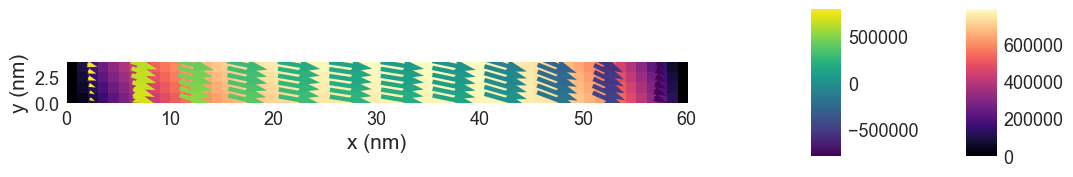

In [466]:
# make figure larger
sim_stage1_fig, sim_stage1_ax1 = plt.subplots(figsize=(12, 6))

# plot vectors on grid of 20 x 5 over the numerical resolution
system_spinchain.m.sel('z').resample((12, 6)).mpl.vector(ax=sim_stage1_ax1)

# add colouring for mx-component to this plot
system_spinchain.m.x.sel('z').mpl.scalar(ax=sim_stage1_ax1, cmap='magma')

##### 4.1.4. Line plot

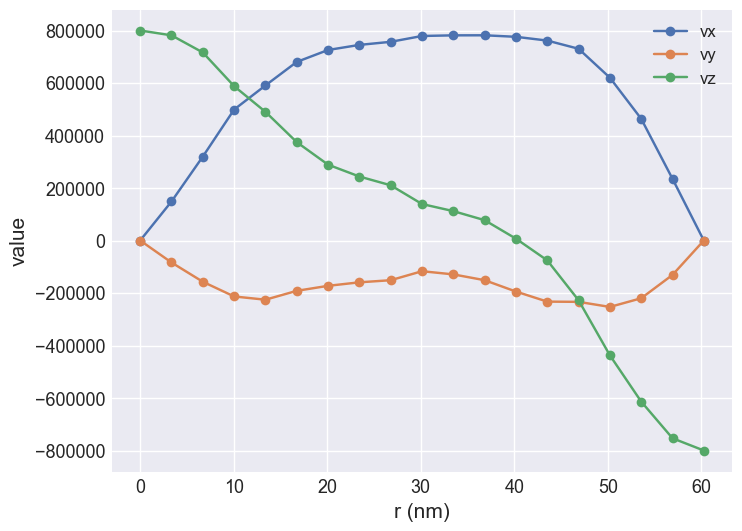

In [467]:
sim_stage1_line = system_spinchain.m.line(p1=system_spinchain.m.mesh.region.pmin,
                               p2=system_spinchain.m.mesh.region.pmax, n=19)
sim_stage1_line.mpl(marker='o')

### 4.2. Dynamic drive

In [468]:
system_spinchain.energy += spinchain_zeeman_dynamic

In [469]:
system_spinchain.energy += spinchain_zeeman_static

ValueError: There is already a term of type <class 'micromagneticmodel.energy.zeeman.Zeeman'> with  name 'SpinchainZeemanStatic' in <class 'micromagneticmodel.energy.energy.Energy'>. Please provide a different name for Zeeman(H=(0.0, 0.0, 79577.47154594767)).

#### 4.2.1. Create driver (TimeDriver)

In [ ]:
spinchain_timedriver = oc.TimeDriver()

#### 4.2.2. Run driver

In [ ]:
spinchain_time_max = 5e-9  # maximum simulated time (s)
spinchain_num_steps = 100  # number of steps during simulation

print(f'Stepsize, h: {spinchain_time_max/spinchain_num_steps} (s)')

In [ ]:
spinchain_timedriver.drive(system_spinchain, 
                           t=spinchain_time_max,
                           n=spinchain_num_steps,
                           verbose=2)

In [ ]:
system_spinchain.m.sel('z').mpl()

#### 4.2.3. Plot data (table)

In [ ]:
system_spinchain.table.data

#### 4.2.4. Plot data (graph)

In [ ]:
system_spinchain.table.mpl(y=['mx', 'my', 'mz'])